In [ ]:
!nvidia-smi

Wed Aug 18 11:02:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    77W / 149W |   8441MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /content/
!cp -r  /content/drive/MyDrive/NIH_Dataset_Customised/NIG_Custom_224.zip /content/
!unzip NIG_Custom_224.zip

/content
Archive:  NIG_Custom_224.zip
replace images/00016568_015.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!cp -r /content/drive/MyDrive/NIHmodified/train_set.csv /content/drive/MyDrive/NIHmodified/val_set.csv /content/

In [ ]:
# cd /content/sample_data

In [ ]:
ls

drive/  images/  NIG_Custom_224.zip  sample_data/  train_set.csv  val_set.csv


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

In [ ]:

import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.compat.v1.logging import INFO, set_verbosity
from skimage import data, img_as_float
from skimage import exposure

random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=256, W=256):
    sample_data = []
    for idx, img in enumerate(df.sample(1000)["Image Index"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std




def load_image(img, image_dir, df, preprocess=True, H=256, W=256):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    x = exposure.equalize_adapthist(x, clip_limit=0.8)
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=256, W=256):
    """GradCAM method for visualizing input saliency."""
    
    
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [ ]:

train_df = pd.read_csv("train_set.csv")
valid_df = pd.read_csv("val_set.csv")


train_df['No Findings'] = pd.to_numeric(train_df['No Findings'], downcast='float')
train_df['Pneumothorax'] = pd.to_numeric(train_df['Pneumothorax'], downcast='float')
train_df['Pneumonia'] = pd.to_numeric(train_df['Pneumonia'], downcast='float')
train_df['Edema'] = pd.to_numeric(train_df['Edema'], downcast='float')
train_df['Effusion'] = pd.to_numeric(train_df['Effusion'], downcast='float')
train_df['Emphysema'] = pd.to_numeric(train_df['Emphysema'], downcast='float')

valid_df['No Findings'] = pd.to_numeric(valid_df['No Findings'], downcast='float')
valid_df['Pneumothorax'] = pd.to_numeric(valid_df['Pneumothorax'], downcast='float')
valid_df['Pneumonia'] = pd.to_numeric(valid_df['Pneumonia'], downcast='float')
valid_df['Edema'] = pd.to_numeric(valid_df['Edema'], downcast='float')
valid_df['Effusion'] = pd.to_numeric(valid_df['Effusion'], downcast='float')
valid_df['Emphysema'] = pd.to_numeric(valid_df['Emphysema'], downcast='float')

valid_df.head()

,Image Index,Patient ID,No Findings,Pneumothorax,Pneumonia,Edema,Effusion,Emphysema
0,00000001_001.png,1,0.0,0.0,0.0,0.0,0.0,1.0
1,00000001_002.png,1,0.0,0.0,0.0,0.0,1.0,0.0
2,00000008_001.png,8,1.0,0.0,0.0,0.0,0.0,0.0
3,00000023_000.png,23,1.0,0.0,0.0,0.0,0.0,0.0
4,00000023_001.png,23,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
labels = ['No Findings',
          'Pneumothorax', 
          'Pneumonia', 
          'Edema', 
          'Effusion',
          'Emphysema' ]

In [ ]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    


    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    

    leakage = len(patients_in_both_groups) > 0

    
    


    # leakage contains true if there is patient overlap, otherwise false.
    #leakage = (patients_in_both_groups > 0) # boolean (true if there is at least 1 patient in both groups)
    
    ### END CODE HERE ###
    
    return leakage

In [ ]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, valid_df, 'Patient ID')))

leakage between train and test: False


In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 256, target_h = 256):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    #image_generator = ImageDataGenerator(
        #samplewise_center=True,
        #samplewise_std_normalization= True)
    
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        brightness_range=[0.2,1.5],
        #featurewise_std_normalization=True,
        
        #contrast_stretching=True, 
        #adaptive_equalization=True, 
        #histogram_equalization=True,
        #zca_whitening=True,
        #zca_epsilon=1e-06,
        zoom_range=0.25
        )




    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=10, batch_size=8, seed=1, target_w = 256, target_h = 256):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col=x_col, 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
IMAGE_DIR = "images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image Index", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, valid_df, train_df, IMAGE_DIR, "Image Index", labels)

getting train generator...
Found 58053 validated image filenames.
getting train and valid generators...
Found 58053 validated image filenames.
Found 23967 validated image filenames.
Found 23967 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


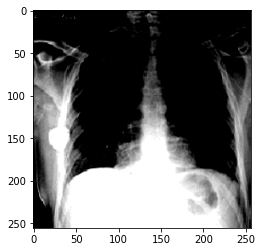

In [ ]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

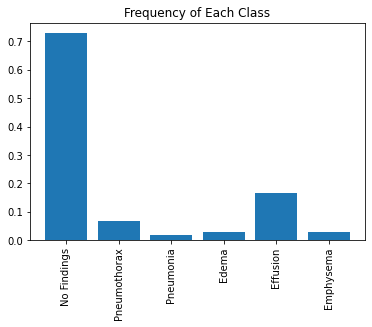

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies =  np.sum(labels, axis=0) / N
    negative_frequencies = np.sum(labels==0, axis=0) / N

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos, freq_neg

(array([0.73002255, 0.06614646, 0.01782854, 0.02933526, 0.16646858,
        0.02988648], dtype=float32),
 array([0.26997743, 0.93385355, 0.98217146, 0.97066474, 0.83353143,
        0.97011352]))

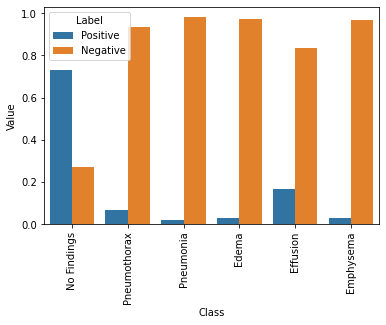

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

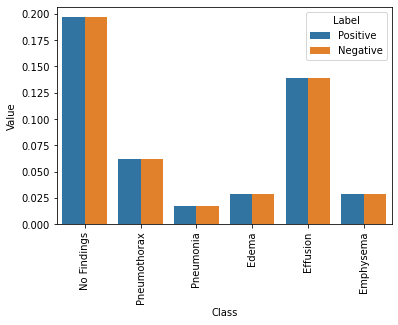

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -1*K.mean((pos_weights[i]* y_true[:, i]*K.log(y_pred[:, i]+ epsilon)+ neg_weights[i]*(1-y_true[:, i])*K.log(1-y_pred[:, i]+ epsilon)))
            #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [ ]:
base_model = DenseNet121(weights='/content/drive/MyDrive/NIHmodified/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Epoch 1/5
100/100 [==============================] - 52s 354ms/step - loss: 0.6871 - val_loss: 1.9072
Epoch 2/5
100/100 [==============================] - 33s 329ms/step - loss: 0.6178 - val_loss: 4.4709
Epoch 3/5
100/100 [==============================] - 33s 328ms/step - loss: 0.6273 - val_loss: 1.4991
Epoch 4/5
100/100 [==============================] - 33s 329ms/step - loss: 0.6828 - val_loss: 5.4456
Epoch 5/5
100/100 [==============================] - 33s 330ms/step - loss: 0.6845 - val_loss: 3.0270


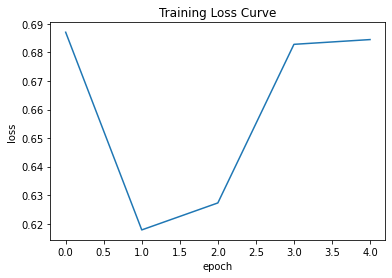

In [ ]:


history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 5)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/NIHModified/DensenetTrain1.h5')

Epoch 1/5
100/100 [==============================] - 33s 331ms/step - loss: 0.6295 - val_loss: 0.6233
Epoch 2/5
100/100 [==============================] - 33s 330ms/step - loss: 0.6282 - val_loss: 1.7397
Epoch 3/5
100/100 [==============================] - 33s 328ms/step - loss: 0.6263 - val_loss: 0.7305
Epoch 4/5
100/100 [==============================] - 33s 330ms/step - loss: 0.6182 - val_loss: 0.7826
Epoch 5/5
100/100 [==============================] - 33s 330ms/step - loss: 0.6085 - val_loss: 0.9666


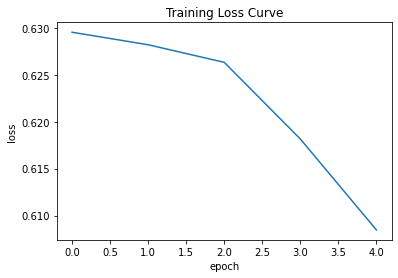

In [ ]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 5)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/NIHModified/DesenetTrain2.h5')

Epoch 1/5
100/100 [==============================] - 33s 332ms/step - loss: 0.6301 - val_loss: 0.7753
Epoch 2/5
100/100 [==============================] - 33s 330ms/step - loss: 0.5927 - val_loss: 1.1550
Epoch 3/5
100/100 [==============================] - 33s 331ms/step - loss: 0.6151 - val_loss: 0.7536
Epoch 4/5
100/100 [==============================] - 33s 331ms/step - loss: 0.6263 - val_loss: 0.6405
Epoch 5/5
100/100 [==============================] - 33s 326ms/step - loss: 0.6215 - val_loss: 0.6331


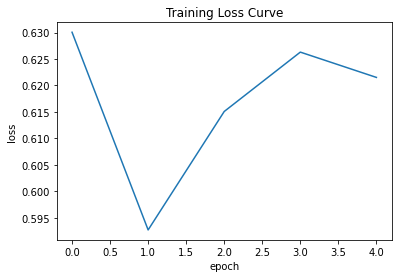

In [ ]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 5)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/NIHModified/DensenetTrain3.h5')

In [ ]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 5)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

Epoch 1/5
100/100 [==============================] - 33s 332ms/step - loss: 0.5868 - val_loss: 1.9995
Epoch 2/5
100/100 [==============================] - 33s 330ms/step - loss: 0.6689 - val_loss: 0.6014
Epoch 3/5
 22/100 [=====>........................] - ETA: 23s - loss: 0.6442

In [ ]:
model.save('/content/drive/MyDrive/NIHModified/DensenetTrain4.h5')

In [ ]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 5)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/NIHModified/DensenetTrain5.h5')

In [ ]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

In [ ]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
df = pd.read_csv("train_set.csv")
IMAGE_DIR = "images/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [ ]:
compute_gradcam(model, "00000011_002.png", IMAGE_DIR, df, labels, labels_to_show)

AttributeError: ignored